In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

from skimage.metrics import peak_signal_noise_ratio

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

In [2]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

print(f'Using device {device}')

Using device cpu


In [3]:
from models import *
from models.unet import *
# Change IMAGE to jet for jet image or snail for snail image
IMAGE = 'snail'

if IMAGE == 'snail':
    net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1], weight_std=1./30)
elif IMAGE == 'jet':
    net = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
else:
    assert False
net.to(device)
print(net)

UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): 

In [4]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 747803


In [5]:
from utils import *
from input_gen import *

reg_noise_std = 1./30.
fname_snail = 'data/denoising/snail.jpg'
fname_jet = 'data/denoising/F16_GT.png'
fname = fname_snail if IMAGE == 'snail' else fname_jet
use_noise = False if IMAGE == 'snail' else True
img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np)
target_img = img_tr
if use_noise:
    target_noisy_img, _ = add_noise_to_tensor(target_img, 'normal', std=reg_noise_std)
else:
    target_noisy_img = target_img
target_noisy_img = target_noisy_img.unsqueeze(dim=0).to(device)
net_input = get_noise(*img_tr.shape, method='noise').unsqueeze(dim=0).detach().to(device)
noise = net_input.detach().clone()
if reg_noise_std > 0:
        net_input = net_input + (noise.normal_() * reg_noise_std)

C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Iteration  100   Loss = 0.027851   PSNR noisy = 15.551625   PSNR gt = 15.551625 
Iteration  200   Loss = 0.013731   PSNR noisy = 18.623064   PSNR gt = 18.623064    
Iteration  300   Loss = 0.007952   PSNR noisy = 20.995302   PSNR gt = 20.995302 
Iteration  400   Loss = 0.005895   PSNR noisy = 22.295359   PSNR gt = 22.295359 
Iteration  500   Loss = 0.004624   PSNR noisy = 23.350155   PSNR gt = 23.350155 
Iteration  600   Loss = 0.004325   PSNR noisy = 23.640045   PSNR gt = 23.640045 
Iteration  700   Loss = 0.003279   PSNR noisy = 24.842204   PSNR gt = 24.842204 
Iteration  800   Loss = 0.003300   PSNR noisy = 24.815389   PSNR gt = 24.815389 
Iteration  900   Loss = 0.002638   PSNR noisy = 25.786468   PSNR gt = 25.786468       
Iteration  1000   Loss = 0.003027   PSNR noisy = 25.189331   PSNR gt = 25.189331 
Iteration  1100   Loss = 0.002594   PSNR noisy = 25.860437   PSNR gt = 25.860437 
Iteration  1200   Loss = 0.002515   PSNR noisy = 25.994161   PSNR gt = 25.994161 
Iteration  1300 

NameError: name 'utils' is not defined

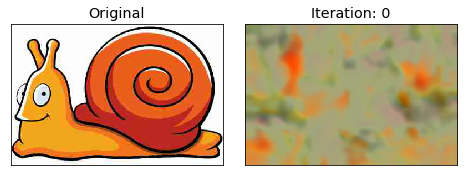

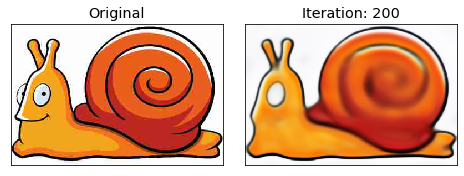

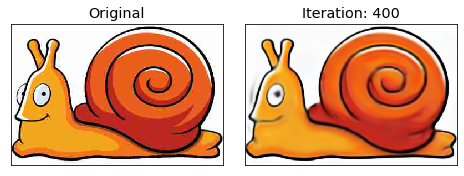

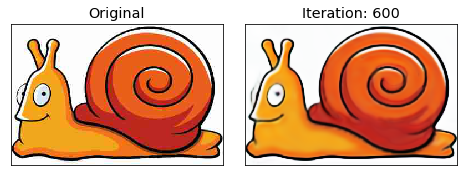

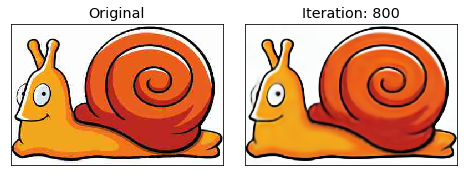

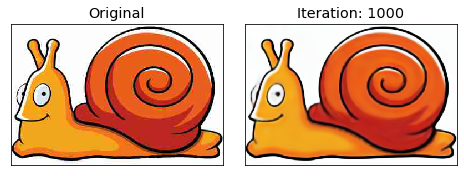

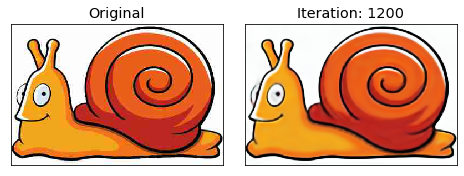

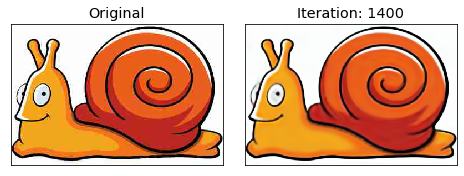

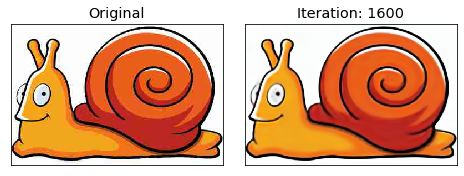

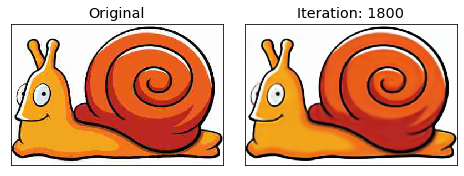

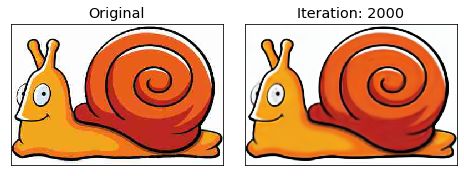

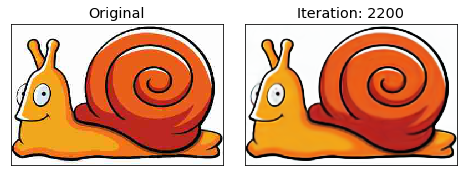

In [6]:
# Training loop, can change hyperparameters mid way
parameters = [x for x in net.parameters()]
LR = 0.01
num_iter = 2400
show_every = 100
optimizer = torch.optim.Adam(parameters, lr=LR)
for i in range(num_iter):
    optimizer.zero_grad()
    out = net(net_input)
    loss = mse(out, target_noisy_img)
    loss.backward()
    psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                         out.detach().cpu().numpy()[0])
    psnr_gt = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    # psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])
    optimizer.step()
    print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {i}'])
print(f'Done training final Loss = {loss.item()}   PSNR = {psnr_noisy}   PSNR gt = {psnr_gt}')
fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'])

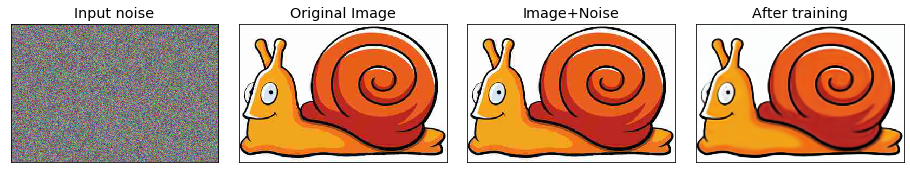

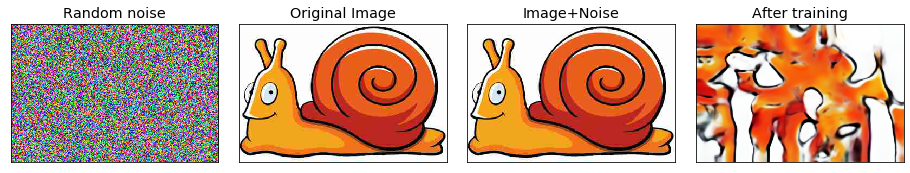

In [7]:
# Showing result of the training using original noise and random noise
with torch.no_grad():
    original_noise = net_input
    output1 = net(original_noise).detach()
    output1 = output1.squeeze(dim=0)
    random_noise = get_noise(*net_input.shape[1:], method='noise').unsqueeze(dim=0)
    output2 = net(random_noise.to(device)).detach()
    output2 = output2.squeeze(dim=0)
    fig, axes = tensors_as_images([original_noise.squeeze(dim=0), img_tr, target_noisy_img.squeeze(dim=0), output1], 
                                        titles=['Input noise', 'Original Image', 'Image+Noise', 'After training'],
                                        figsize=(16,16))
    fig, axes = tensors_as_images([random_noise.squeeze(dim=0), img_tr, target_noisy_img.squeeze(dim=0), output2], 
                                        titles=['Random noise', 'Original Image', 'Image+Noise', 'After training'],
                                        figsize=(16,16))
    output_pil = np_to_pil(output1.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}.png')
# will need to use original noise to do denoising

 Best PSNR = 26.411674   Best p = 0.010500


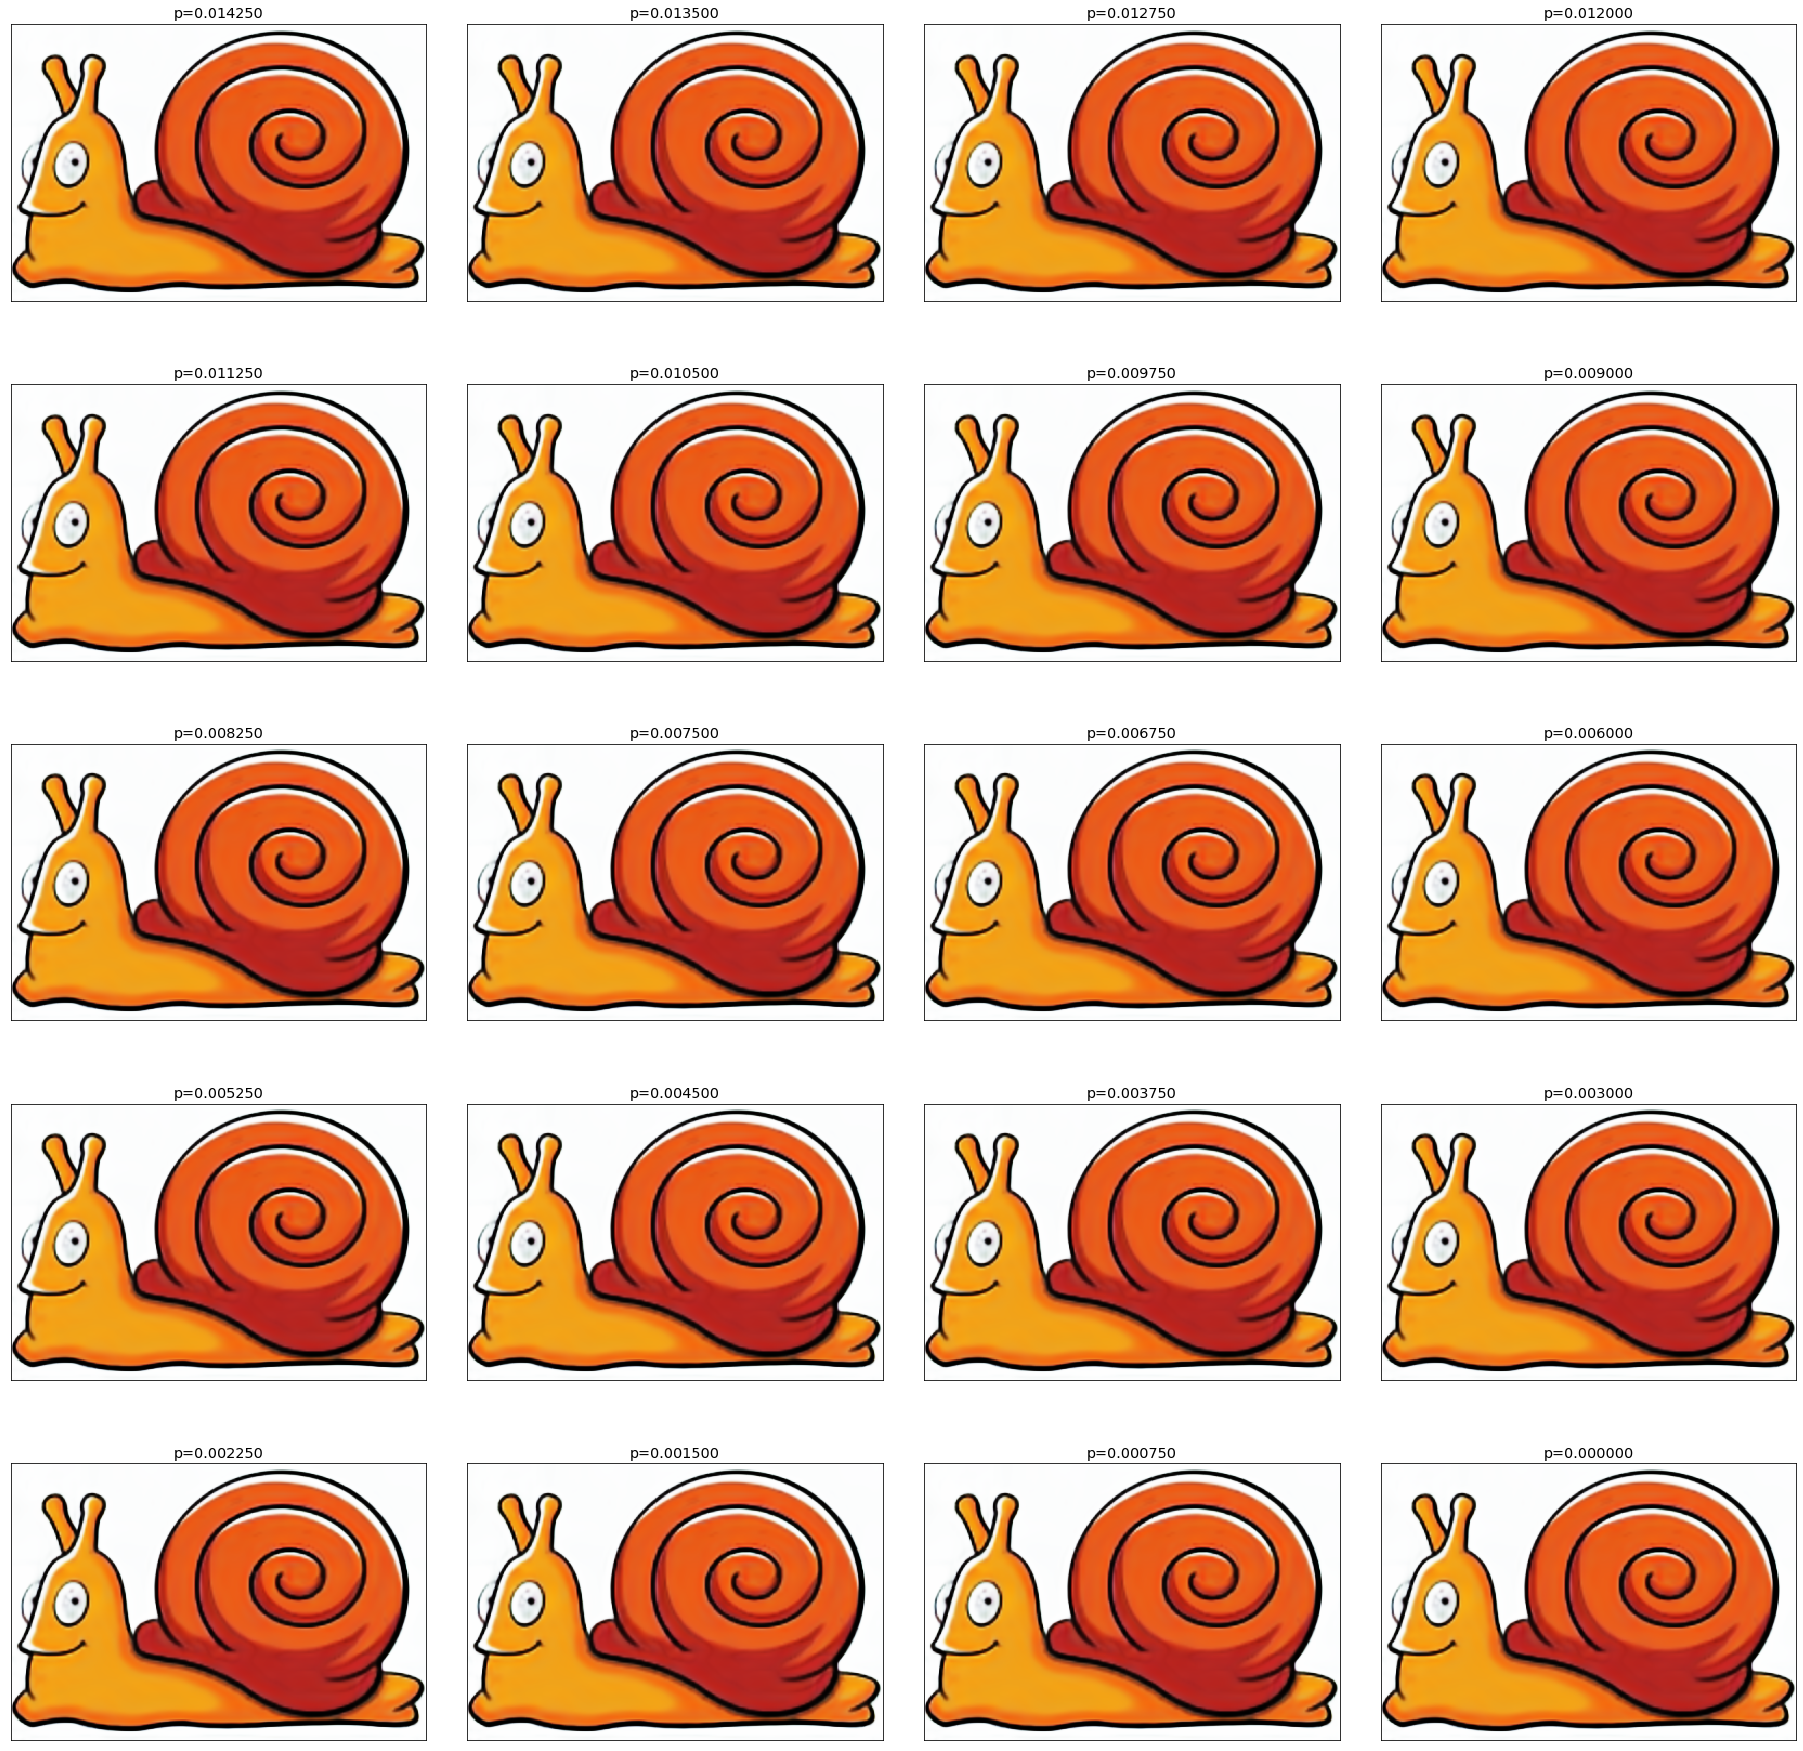

In [8]:
# Try to get better results by changing z_input a bit
with torch.no_grad():
    a = torch.rand(*original_noise.shape)  
    best_psnr = 0
    best_p = 0
    results = []
    values = list(np.arange(0.000, 0.015, 0.015/20))
    for p in reversed(values):
        a[abs(a) > p] = 0
        new_noise = original_noise + a.to(device)
        output = net(new_noise).detach()
        psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                             output.detach().cpu().numpy()[0])
        psrn_gt    = peak_signal_noise_ratio(img_np, output.detach().cpu().numpy()[0]) 
        # psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0]) 
        output = output.squeeze(dim=0)
        results.append(output.clone())
        #print(f'With new noise PSNR = {psnr_noisy}')
        if psnr_noisy > best_psnr:
            best_psnr = psnr_noisy
            best_p = p
    print(f' Best PSNR = %f   Best p = %f' % (best_psnr, best_p))
    nrows = int(len(values)/4)
    fig, axes = tensors_as_images(results, titles=[f'p=%f' % p for p in reversed(values)],
                                        nrows=nrows, figsize=(32,32))
        